Loading and Merging

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

Loading preprocessed data:

In [29]:
# loading X_train, X_test, y_train, y_test
X = pd.read_csv('data/X.csv')
y = pd.read_csv('data/y.csv')

In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76822 entries, 0 to 76821
Columns: 495 entries, age to job_end_2019
dtypes: bool(259), float64(236)
memory usage: 157.3 MB



EDA label variable

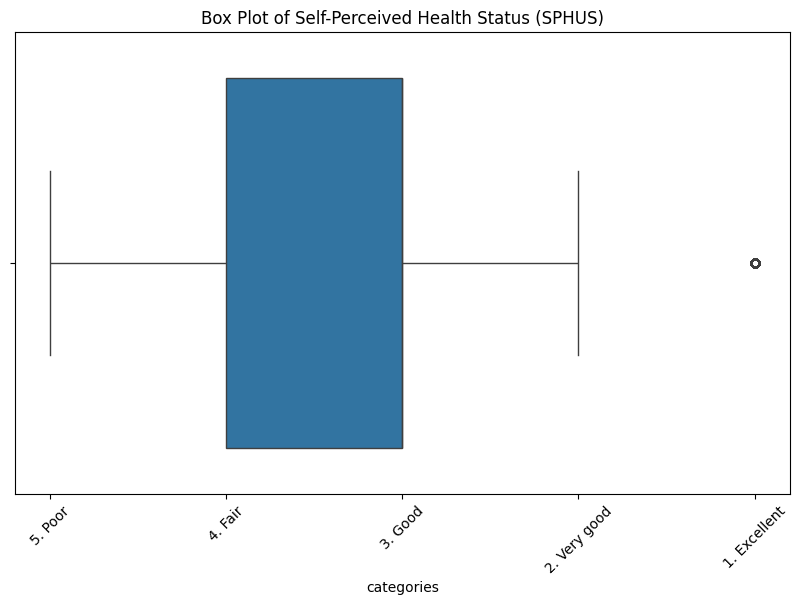

In [31]:
# box plot - doesn't make sense to do boxplot??
plt.figure(figsize=(10, 6))
sns.boxplot(x=y['sphus'])
plt.title('Box Plot of Self-Perceived Health Status (SPHUS)')
plt.xlabel('categories')
plt.xticks(rotation=45)
plt.show()

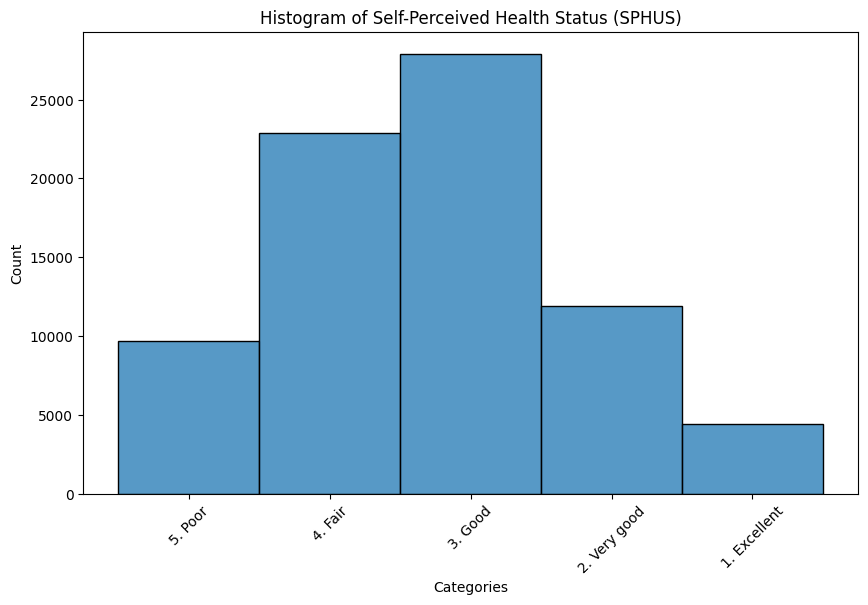

In [32]:
# histo
plt.figure(figsize=(10, 6))
sns.histplot(y['sphus'], discrete=True)
plt.title('Histogram of Self-Perceived Health Status (SPHUS)')
plt.xlabel('Categories')
plt.xticks(rotation=45)
plt.show()

Grouped Feature Selection

In [33]:
variable_names = X.columns.tolist()

# Initialize lists for each category
temperature_vars = []
radiation_vars = []
precipitation_vars = []
pollution_vars = {'PM2.5': [], 'PM10': [], 'NO2': [], 'O3': []}
flood_vars = []
heating_cooling_vars = []  # For Heating Degree Days (HDD) and Cooling Degree Days (CDD)

for var in variable_names:
    # Temperature variables
    if 'tn_' in var or 'tg_' in var or 'tx_' in var:
        temperature_vars.append(var)
    
    # Radiation variables
    elif 'radiation' in var:
        radiation_vars.append(var)
    
    # Precipitation variables
    elif 'prec' in var:
        precipitation_vars.append(var)
    
    # Pollution variables
    elif 'pm2p5' in var or 'conc_pm2p5' in var:
        pollution_vars['PM2.5'].append(var)
    elif 'pm10' in var or 'conc_pm10' in var:
        pollution_vars['PM10'].append(var)
    elif 'no2' in var or 'conc_no2' in var:
        pollution_vars['NO2'].append(var)
    elif 'o3' in var or 'conc_o3' in var:
        pollution_vars['O3'].append(var)
    
    # Flood variables
    elif 'fl_' in var:
        flood_vars.append(var)
    
    # Heating and Cooling Degree Days
    elif 'HDD' in var or 'CDD' in var:
        heating_cooling_vars.append(var)

In [34]:
feature_groups = {
    'temperature': temperature_vars,
    'radiation': radiation_vars,
    'precipitation': precipitation_vars,
    'pollution_PM2.5': pollution_vars['PM2.5'],
    'pollution_PM10': pollution_vars['PM10'],
    'pollution_NO2': pollution_vars['NO2'],
    'pollution_O3': pollution_vars['O3'],
    'floods': flood_vars,
    'heating_cooling': heating_cooling_vars
}

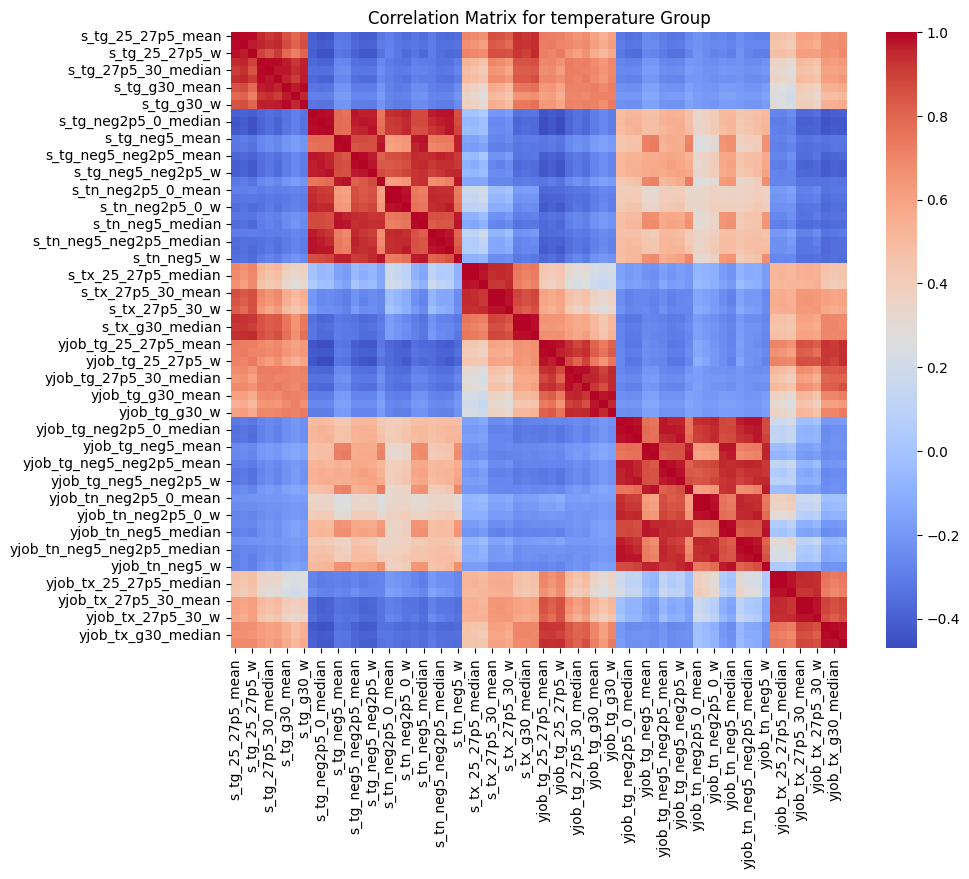

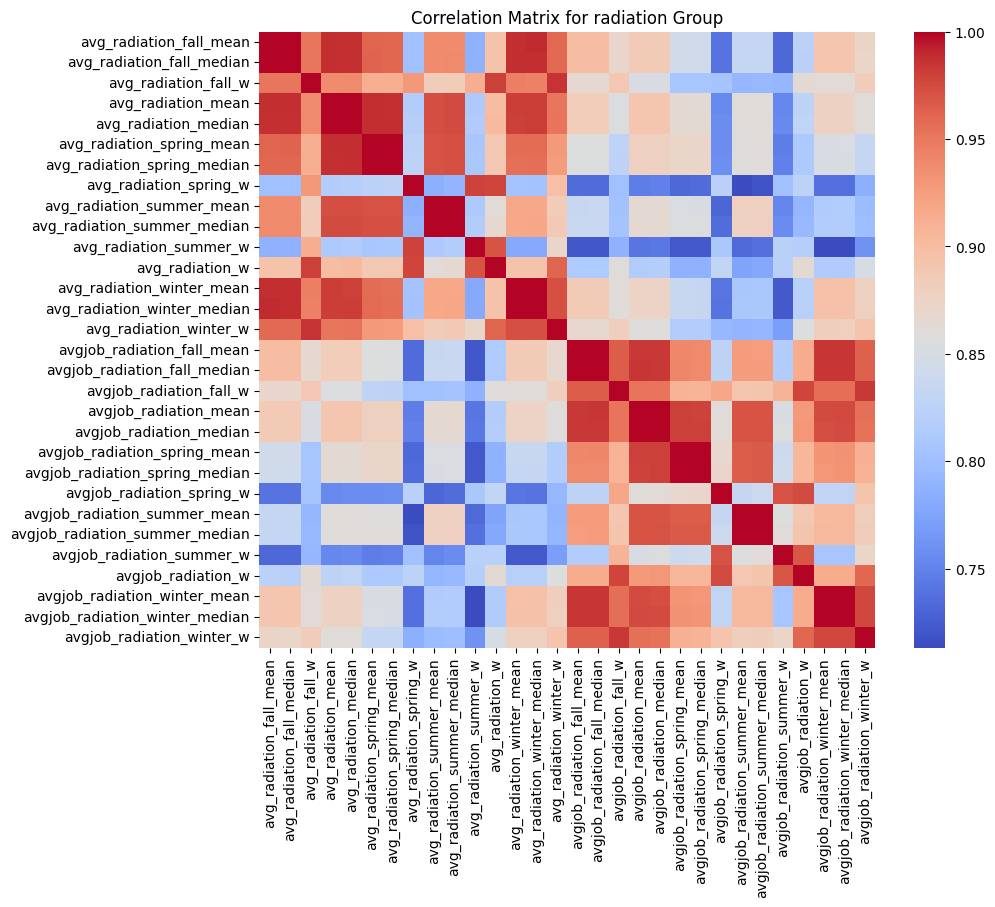

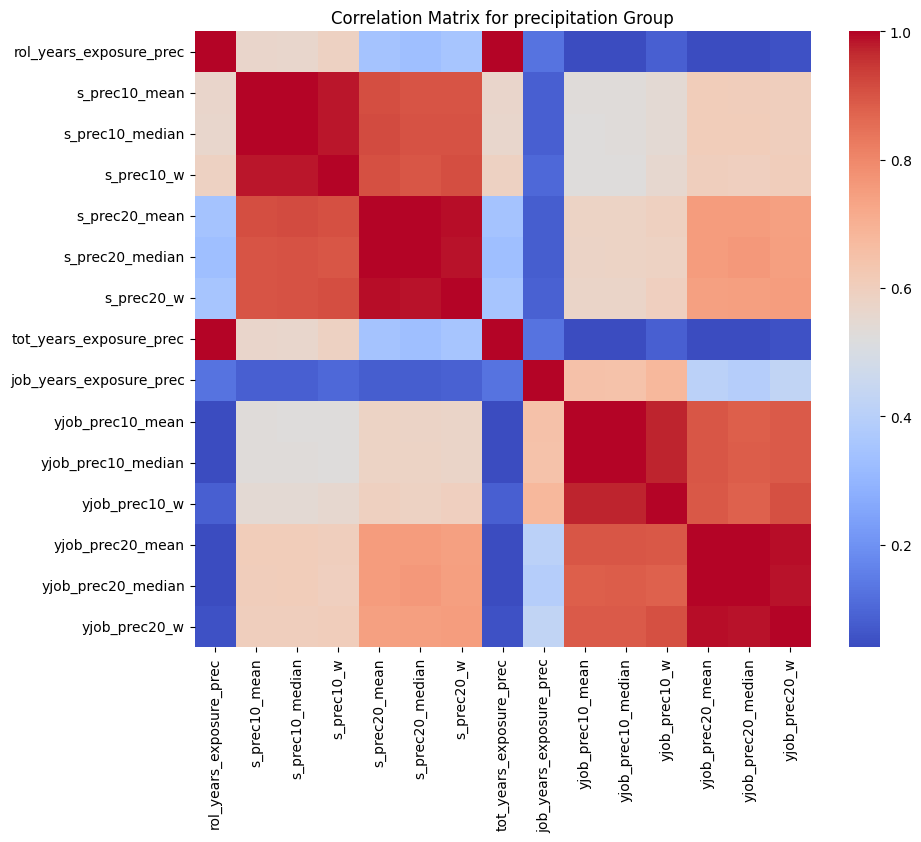

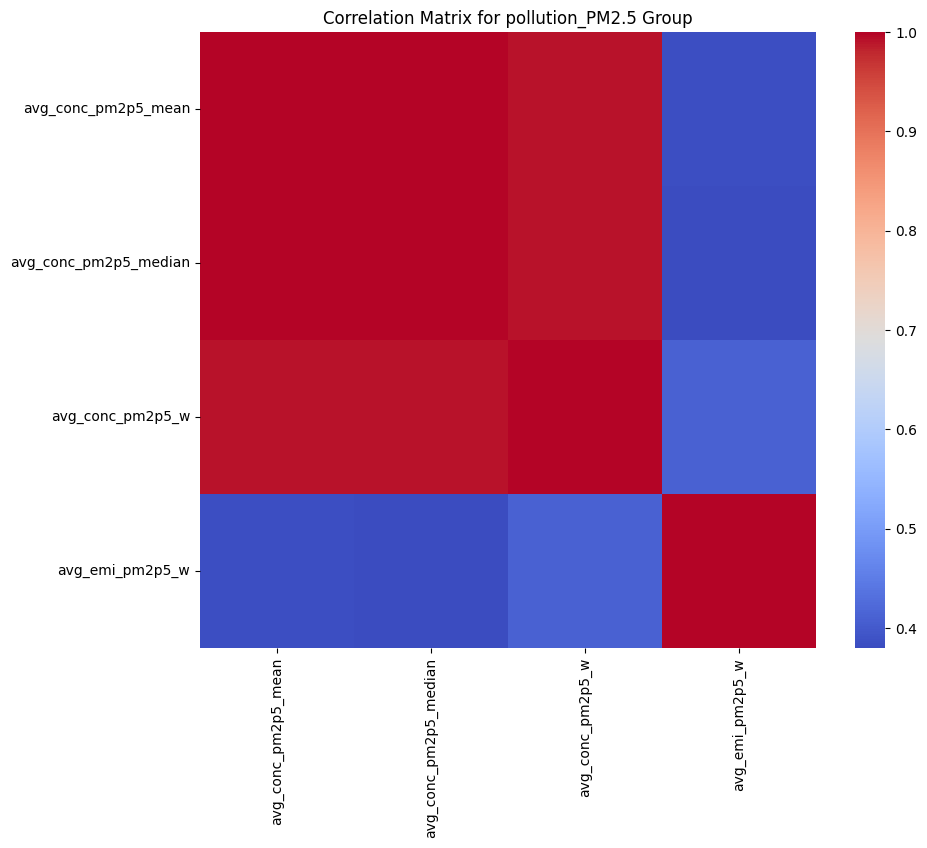

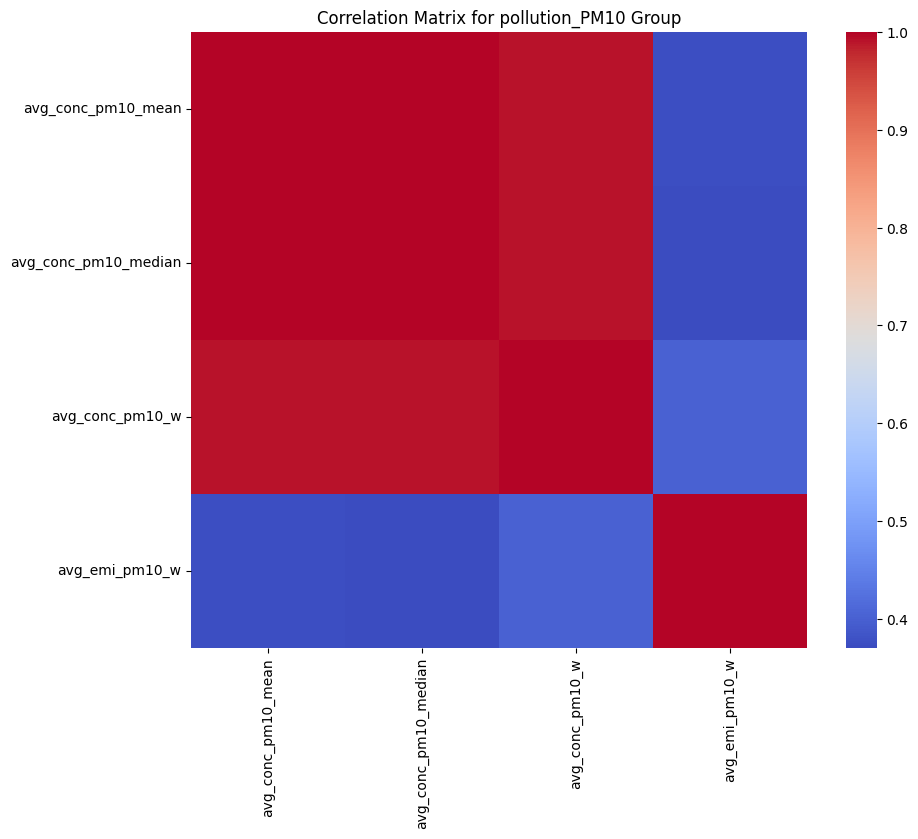

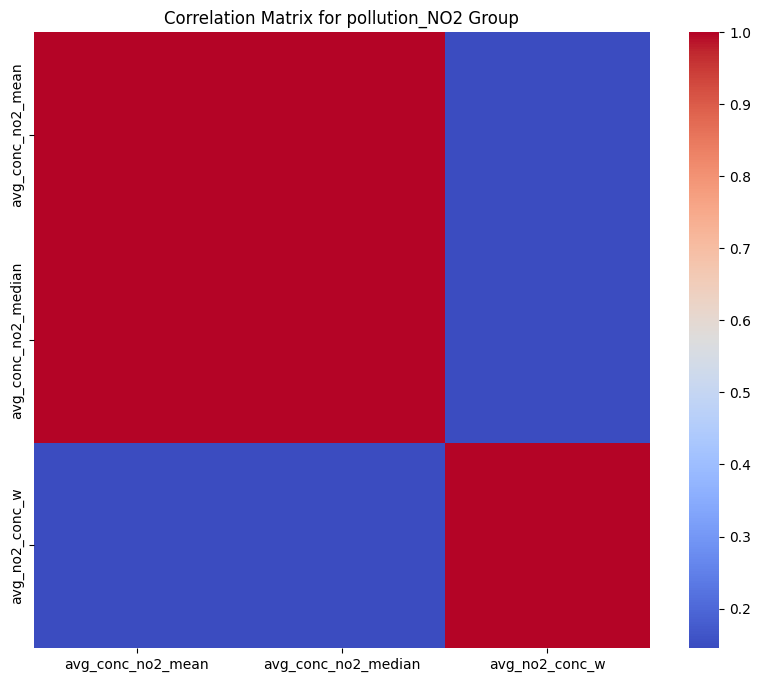

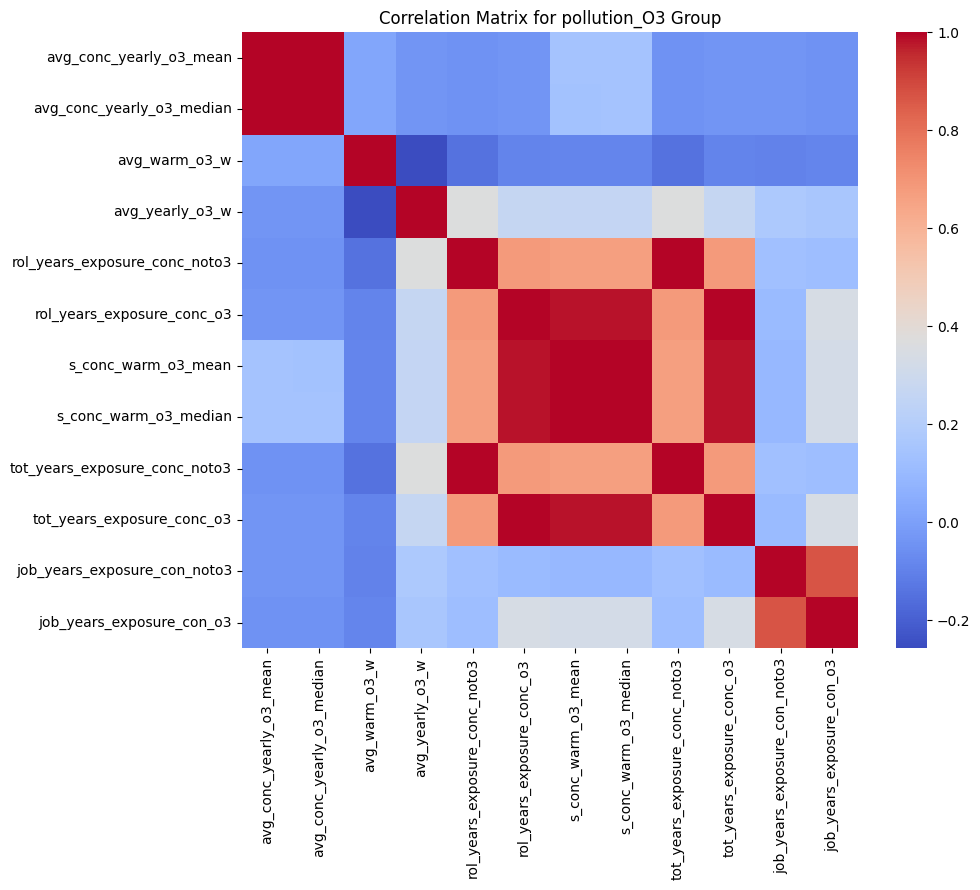

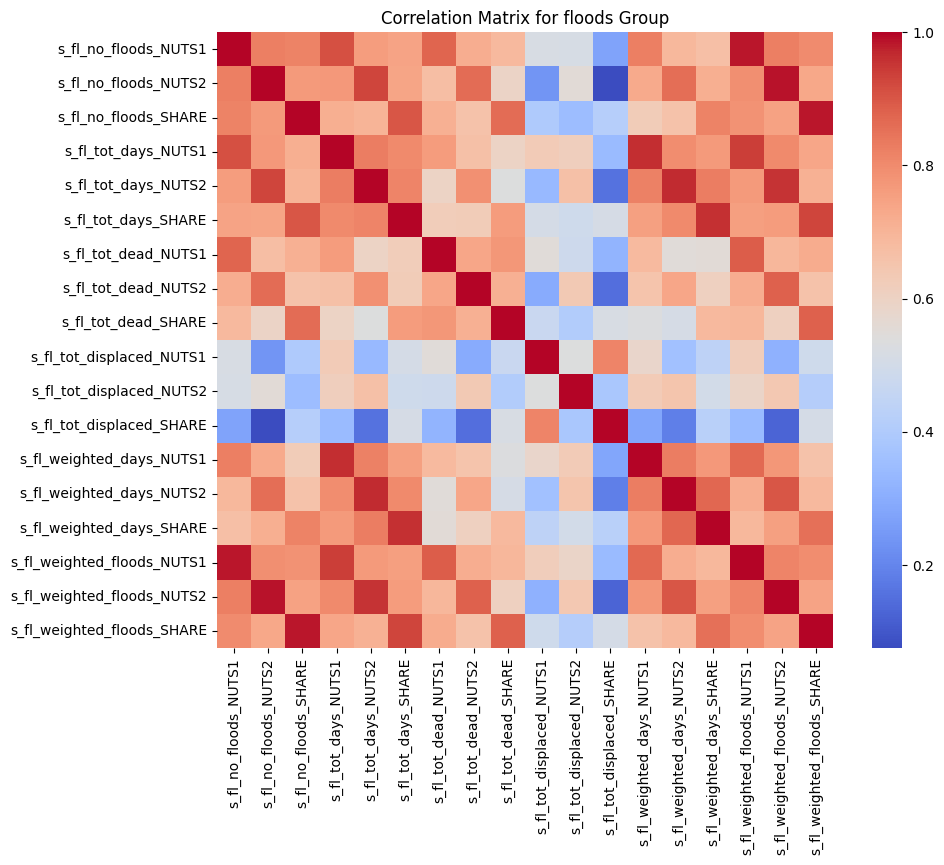

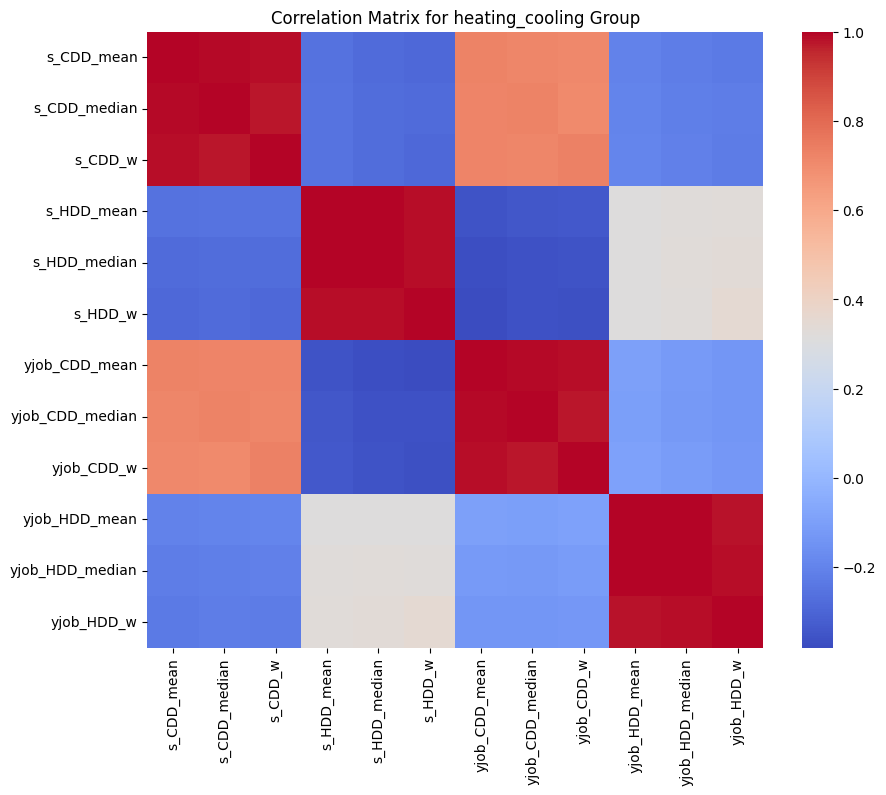

In [35]:
for group_name, features in feature_groups.items():
    # Filter the DataFrame to keep only the current group's features
    df_group = X[features]
    
    # Calculate the correlation matrix
    corr_matrix = df_group.corr()
    
    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    plt.title(f'Correlation Matrix for {group_name} Group')
    plt.show()

Split the data

In [36]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Imputing categorical with most frequent and doing one hot encoding:

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=5)

# Dictionary to store the most important features by group
best_features = {}

# Iterate over each feature group to identify the most important feature
for group_name, features in feature_groups.items():
    # Ensure the feature group is not empty and contains valid features
    if not features:
        continue
    
    # Select the current group's features from the scaled training data
    # Check if the feature group exists in the cleaned and scaled data
    valid_features = X_train.columns.intersection(features)

    if valid_features.empty:
        print(f"{group_name}: No valid features after data preparation.")
        continue

    # Train the Random Forest model on the selected features
    rf_model.fit(X_train[valid_features], y_train)

    # Get the feature importances and find the most important one
    importances = rf_model.feature_importances_
    most_important_feature = valid_features[np.argmax(importances)]
    best_features[group_name] = most_important_feature

    # Optionally, evaluate the model's performance on the test data
    predictions = rf_model.predict(X_test[valid_features])
    accuracy = accuracy_score(y_test, predictions)
    print(f"{group_name} - Most Important Feature: {most_important_feature}, Accuracy: {accuracy:.4f}")

# Output the best features from each group
print("Best Features by Group:", best_features)

/Users/linozurmuhl/miniforge3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


temperature - Most Important Feature: s_tg_neg5_neg2p5_w, Accuracy: 0.4041


/Users/linozurmuhl/miniforge3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


radiation - Most Important Feature: avgjob_radiation_winter_mean, Accuracy: 0.3948


/Users/linozurmuhl/miniforge3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


precipitation - Most Important Feature: tot_years_exposure_prec, Accuracy: 0.3989


/Users/linozurmuhl/miniforge3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


pollution_PM2.5 - Most Important Feature: avg_conc_pm2p5_median, Accuracy: 0.3900


/Users/linozurmuhl/miniforge3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


pollution_PM10 - Most Important Feature: avg_conc_pm10_median, Accuracy: 0.3898


/Users/linozurmuhl/miniforge3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


pollution_NO2 - Most Important Feature: avg_conc_no2_median, Accuracy: 0.3867


/Users/linozurmuhl/miniforge3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


pollution_O3 - Most Important Feature: job_years_exposure_con_o3, Accuracy: 0.3928


/Users/linozurmuhl/miniforge3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


floods - Most Important Feature: s_fl_tot_days_NUTS1, Accuracy: 0.3794


/Users/linozurmuhl/miniforge3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


heating_cooling - Most Important Feature: s_CDD_w, Accuracy: 0.3926
Best Features by Group: {'temperature': 's_tg_neg5_neg2p5_w', 'radiation': 'avgjob_radiation_winter_mean', 'precipitation': 'tot_years_exposure_prec', 'pollution_PM2.5': 'avg_conc_pm2p5_median', 'pollution_PM10': 'avg_conc_pm10_median', 'pollution_NO2': 'avg_conc_no2_median', 'pollution_O3': 'job_years_exposure_con_o3', 'floods': 's_fl_tot_days_NUTS1', 'heating_cooling': 's_CDD_w'}


In [38]:
# Step 1: Convert best_features values to a set for faster lookup
best_features_set = set(best_features.values())

# Step 2: Initialize a list to hold variables to drop
vars_to_drop = []

# Step 3: Identify variables to drop from each feature group
for group_name, features in feature_groups.items():
    vars_to_drop.extend([var for var in features if var not in best_features_set])

# Step 4: Drop these unwanted variables from the scaled DataFrames
X_train_selected = X_train.drop(columns=vars_to_drop, errors='ignore')
X_test_selected = X_train.drop(columns=vars_to_drop, errors='ignore')

# Step 6: Output the shape of original and modified DataFrames to check consistency
print("Original X_train_scaled_df shape:", X_train.shape)
print("Modified X_train_s_scaled shape:", X_train_selected.shape)

print("Original X_test_scaled_df shape:", X_test.shape)
print("Modified X_test_s_scaled shape:", X_test_selected.shape)

Original X_train_scaled_df shape: (61457, 495)
Modified X_train_s_scaled shape: (61457, 334)
Original X_test_scaled_df shape: (15365, 495)
Modified X_test_s_scaled shape: (61457, 334)


In [43]:
#lgositic regrassion model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42, max_iter=200)

# Train the model on the selected features
log_reg_model.fit(X_train_selected, y_train)

# Make predictions on the test data
predictions = log_reg_model.predict(X_test_selected)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print(f"Logistic Regression Model Accuracy: {accuracy:.4f}")

/Users/linozurmuhl/miniforge3/envs/ML/lib/python3.12/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/linozurmuhl/miniforge3/envs/ML/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: Found input variables with inconsistent numbers of samples: [15365, 61457]

In [39]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a new RandomForestClassifier
rf_top_grouped = RandomForestClassifier(random_state=42)

# Fit the RandomForest model on the selected and scaled training data
rf_top_grouped.fit(X_test_selected, y_train)

# Get the parameters of the fitted RandomForestClassifier instance
rf_grouped_parameters = rf_top_grouped.get_params()

# Display each parameter and its value
print("Parameters of the RandomForestClassifier:")
for param, value in rf_grouped_parameters.items():
    print(f"The parameter '{param}' is set to {value}.")

/Users/linozurmuhl/miniforge3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Parameters of the RandomForestClassifier:
The parameter 'bootstrap' is set to True.
The parameter 'ccp_alpha' is set to 0.0.
The parameter 'class_weight' is set to None.
The parameter 'criterion' is set to gini.
The parameter 'max_depth' is set to None.
The parameter 'max_features' is set to sqrt.
The parameter 'max_leaf_nodes' is set to None.
The parameter 'max_samples' is set to None.
The parameter 'min_impurity_decrease' is set to 0.0.
The parameter 'min_samples_leaf' is set to 1.
The parameter 'min_samples_split' is set to 2.
The parameter 'min_weight_fraction_leaf' is set to 0.0.
The parameter 'monotonic_cst' is set to None.
The parameter 'n_estimators' is set to 100.
The parameter 'n_jobs' is set to None.
The parameter 'oob_score' is set to False.
The parameter 'random_state' is set to 42.
The parameter 'verbose' is set to 0.
The parameter 'warm_start' is set to False.


In [41]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [10, 50],  # Simplified for speed
    'max_depth': [None, 5, 10],   # Reduced options
    'min_samples_split': [2, 4],  # Default and one variation
}

rf = RandomForestClassifier(random_state=42)

cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)  

try:
    cv_rf.fit(X_train_selected, y_train)  
except Exception as e:
    print("Error during GridSearchCV fitting:", e)  

try:
    y_pred = cv_rf.predict(X_test_selected) 
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
except Exception as e:
    print("Error during prediction:", e)  

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/linozurmuhl/miniforge3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/linozurmuhl/miniforge3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/linozurmuhl/miniforge3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/linozurmuhl/miniforge3/envs/ML/lib/python3.12/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vec

Error during prediction: Found input variables with inconsistent numbers of samples: [15365, 61457]


Initial Random Forest Fitting and Feature Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize the limited Random Forest model
rf_limitted = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=5)

# Feature counts to evaluate
feature_counts = [50, 100, 150, 200, X_train.shape[1]]  # Evaluate different feature counts

# Dictionary to store the average accuracy for each feature count
results = {}

# Iterate over the feature counts
for count in feature_counts:
    # Select the first N features
    X_train_subset = X_train[:, :count]
    X_test_subset = X_train[:, :count]

    # Re-fit the imputation and scaling pipeline
    X_train_scaled_subset = pipeline.fit_transform(X_train_subset)  # Re-fit for each subset
    X_test_scaled_subset = pipeline.transform(X_test_subset)

    # Evaluate the model with cross-validation
    scores = cross_val_score(rf_limitted, X_train_scaled_subset, y_train, cv=5, scoring='accuracy')

    # Store the average accuracy for this feature count
    results[count] = np.mean(scores)
    print(f"Average accuracy with top {count} features: {results[count]:.4f}")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification

# Generate sample data with 20 features
X, y = make_classification(n_samples=500, n_features=20, random_state=42)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline with imputation and scaling
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Fit and transform the training data
X_train_cleaned = pipeline.fit_transform(X_train)

# Transform the testing data
X_test_cleaned = pipeline.transform(X_test)

# Create feature names based on the number of columns
num_features = X_train_cleaned.shape[1]
feature_names = [f'Feature_{i}' for i in range(num_features)]

# Convert cleaned data to DataFrames with feature names
X_train_df = pd.DataFrame(X_train_cleaned, columns=feature_names)
X_test_df = pd.DataFrame(X_test_cleaned, columns=feature_names)

# Fit the Random Forest model on the cleaned training data
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=5)
rf.fit(X_train_df, y_train)

# Get feature importances and sort them
feature_importances = rf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1][:10]  # Top 10 features

# Plot the top 10 feature importances
plt.figure(figsize=(8, 6))
plt.bar(range(10), feature_importances[sorted_indices], align='center', alpha=0.5)
plt.xticks(range(10), [feature_names[i] for i in sorted_indices], rotation=90, fontsize=10)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

Refitting model with 100 features

In [ ]:
feature_importances = rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
top_100_indices = sorted_indices[:100]

top_100_feature_names = X_train_scaled_df.columns[top_100_indices]

all_feature_names = X_train_scaled_df.columns.tolist()

rejected_feature_names = [feature for feature in all_feature_names if feature not in top_100_feature_names]

print("Top 100 features:")
print(top_100_feature_names.tolist())

print("Rejected features:")
print(rejected_feature_names)

PCA

In [ ]:
#From df_relevant = replace_dash_with_na(df_relevant)

In [ ]:
numeric_imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

In [ ]:
numeric_cols = df_relevant.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df_relevant[numeric_cols]

In [ ]:
pipeline = Pipeline([
    ('imputer', numeric_imputer),
    ('scaler', StandardScaler())
])

df_cleaned = pipeline.fit_transform(df_numeric)

In [ ]:
n_components = min(df_cleaned.shape[0], df_cleaned.shape[1])  
pca = PCA(n_components=n_components)

df_pca = pca.fit_transform(df_cleaned)

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Explained Variance Ratio by PCA Components')
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [ ]:
cumulative_explained_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('PCA Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [ ]:
n_optimal_components = len(cumulative_explained_variance[cumulative_explained_variance < 0.90]) + 1

In [ ]:
pca_subset = df_pca[:, :n_optimal_components]

In [ ]:
pca_loadings = pca.components_

In [ ]:
print("Shape of PCA loadings:", pca_loadings.shape)

In [ ]:
first_component = pca_loadings[0] 

In [ ]:
top_features_indices = np.argsort(np.abs(first_component))[::-1]

In [ ]:
top_features_names = df_numeric.columns[top_features_indices]

In [ ]:
print("Top features for the first principal component:")
print(top_features_names[:20])

PCA Lists

In [ ]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute with mean for numerical data
    ('scaler', StandardScaler())  # Standardize features
])

In [ ]:
pca_subsets = {}
for group_name, features in feature_groups.items():
    df_group = df_relevant[features]  # Select features for this group
    df_group_cleaned = pipeline.fit_transform(df_group)  # Clean and scale

    # Fit a new PCA model for this group
    n_components = min(df_group_cleaned.shape[0], df_group_cleaned.shape[1])
    group_pca = PCA(n_components=n_components)  # Fit with the correct feature count
    df_group_pca = group_pca.fit_transform(df_group_cleaned)  # Apply PCA
    
    # Determine the optimal number of components based on explained variance
    cumulative_explained_variance = group_pca.explained_variance_ratio_.cumsum()
    optimal_components = np.where(cumulative_explained_variance >= 0.90)[0][0] + 1  # At least 90% variance
    
    # Retain only the optimal number of components
    pca_subsets[group_name] = df_group_pca[:, :optimal_components]

In [ ]:
for group_name, subset in pca_subsets.items():
    print(f"Feature count for '{group_name}':", subset.shape[1])
# count how many features are in each subset after applying PCA with the optimal number of components.

Combining PCA

In [ ]:
import numpy as np

In [ ]:
combined_pca = np.hstack([pca_subsets[group_name] for group_name in pca_subsets.keys()])

print("Combined PCA subset shape:", combined_pca.shape)

Random Forest on General PCA

In [ ]:
df_relevant = df_relevant.dropna(subset=['sphus'])
X = df_relevant.drop('sphus', axis=1) 
y = df_relevant['sphus']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_columns)

In [ ]:
for column in non_numeric_columns:
    unique_values = X[column].unique()
    print(f"Unique values in '{column}':", unique_values)

In [ ]:
for column in non_numeric_columns:
    try:
        X[column] = pd.to_numeric(X[column], errors='raise')
    except ValueError as ve:
        print(f"Conversion failed for '{column}':", ve)

In [ ]:
numeric_columns = X.select_dtypes(include=[np.number]).columns
non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns

In [ ]:
nan_columns = X_train.columns[X_train.isnull().any()]

print("Columns with NaNs:", nan_columns)

# Check for NaNs in categorical features
nan_categorical_features = [col for col in categorical_features if X_train[col].isnull().any()]

print("Categorical features with NaNs:", nan_categorical_features)

In [ ]:
for col in categorical_features:
    X_train[col] = X_train[col].astype('category', errors='ignore')

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

In [ ]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

In [ ]:
for col in categorical_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),  
        ('cat', categorical_transformer, categorical_features) 
    ]
)

In [ ]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
print("Preprocessing completed successfully.")

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [ ]:
n_components = 20  
svd = TruncatedSVD(n_components=n_components)

X_train_svd = svd.fit_transform(X_train_preprocessed)
X_test_svd = svd.transform(X_test_preprocessed)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_svd, y_train)

y_pred = rf.predict(X_test_svd)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Random Forest with SVD - Accuracy:", accuracy)
print("Classification Report:\n", report)

On Subset

In [ ]:
y = df_relevant.dropna(subset=['sphus'])['sphus'].iloc[:len(combined_pca)]

In [ ]:
y_corrected = df_relevant.dropna(subset=['sphus'])['sphus']

# Ensure combined_pca has the same number of samples
combined_pca_aligned = combined_pca[:len(y_corrected)]

# Check that they now have the same length
print("Length of combined_pca:", len(combined_pca_aligned))
print("Length of y_corrected:", len(y_corrected))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(combined_pca_aligned, y_corrected, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)  

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Random Forest on combined PCA - Accuracy:", accuracy)
print("Classification Report:\n", report)

Logistic Reg on general PCA

In [ ]:
n_components = 20 
svd = TruncatedSVD(n_components=n_components)

In [ ]:
X_train_svd = svd.fit_transform(X_train_preprocessed)
X_test_svd = svd.transform(X_test_preprocessed)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_reg = LogisticRegression(
    random_state=42, max_iter=1000, solver='liblinear',  # New solver and more iterations
    C=0.5  # Increase regularization
)
# was forced otherwise error of convergence => couldn't converge with this nb of iterations...

In [ ]:
log_reg.fit(X_train_svd, y_train)

In [ ]:
y_pred = log_reg.predict(X_test_svd)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Logistic Regression with Adjusted Parameters - Accuracy:", accuracy)
print("Classification Report:\n", report)

Log reg on combined_pca

In [ ]:
combined_pca_aligned = combined_pca[:len(y)] # we need to check that combined PCA has same length as clean y ie y with dropped nas of sphus

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_pca_aligned, y, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.utils import class_weight

In [ ]:
class_distribution = y_train.value_counts(normalize=True)
print("Class Distribution in Training Set:\n", class_distribution)

In [ ]:
log_reg = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='liblinear',  # 'liblinear' is useful for smaller datasets
    class_weight='balanced'  # Adjust class weights for imbalance => we have imbalance so it's good to use balanced
)

In [ ]:
log_reg.fit(X_train, y_train)

In [ ]:
y_pred = log_reg.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)  # Use zero_division to avoid undefined warnings

print("Logistic Regression on Combined PCA - Accuracy:", accuracy)
print("Classification Report:\n", report)

SOME INTERPRETATIONS OF THIS:  first few components of the PCA are capturing the majority of the variance within our dataset. A few components are able to explain much of the variability in the data, which suggests that these components capture significant underlying patterns or factors in the dataset. FROM CUMULATIVE: Reaching around 10 components, we've captured approximately 90% of the variance. This is good => can reduce the dimensionality of data significantly without losing too much information, which is one of the primary goals of using PCA in data preprocessing for machine learning.

Random Forest with General PCA : accuracy : 43%: model performed relatively well on the 'Good' category but poorly on 'Excellent' and 'Very good'.Imbalance in the dataset where 'Good' had more data points, allowing the model to learn better??

Random Forest on Combined PCA : Accuracy: 32%: lower performance across all categories compared to the general PCA approach. Combined PCA didn't capture the necessary variance as effectively or the dataset became too complex.

Logistic Regression with Adjusted Parameters (General PCA): Accuracy: 44%. Similar to the Random Forest model, Logistic Regression performed better on the 'Good' category and had no predictions for 'Excellent' and 'Very good'. It indicates a potential issue with class imbalance.

Logistic Regression on Combined PCA: Accuracy: 32% : Performance was generally poor across all categories, similar to the Random Forest model on the same data transformation. This suggests that the combined PCA might not be providing useful features for the model or that logistic regression is not suitable for this high-dimensional, transformed data.

WHAT SAYS CHATGPT? Model Suitability: The Logistic Regression seems slightly better than Random Forest when using general PCA but not significantly. Both models struggle with the combined PCA, suggesting issues with how the PCA was applied or the nature of data in those components.
Data Imbalance: Your dataset suffers from class imbalance, which is affecting the performance, particularly in minority classes ('Excellent' and 'Very good'). Techniques to address this, like adjusting class weights or using oversampling methods, might help improve model performance.
PCA Application: The general PCA (using SVD) appears more effective than the combined PCA from grouped features. This might be because the grouped PCA dilutes important individual features across too many principal components, reducing the effectiveness of the model.

Varying PCA components

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
pca = PCA().fit(df_cleaned)  
explained_variance = pca.explained_variance_ratio_

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

In [ ]:
cumulative_variance = np.cumsum(explained_variance)
n_components_90 = np.where(cumulative_variance >= 0.90)[0][0] + 1
print(f"Number of components explaining 90% of variance: {n_components_90}")

In [ ]:
pca_optimal = PCA(n_components=n_components_90)
X_pca_optimal = pca_optimal.fit_transform(df_cleaned)  

Kernel PCA => explore if the non-linear kernel-based approach captures more complex patterns that could be beneficial for models

In [ ]:
from sklearn.decomposition import KernelPCA

In [ ]:
import numpy as np

In [ ]:
kernel_pca = KernelPCA(n_components=n_components_90, kernel='rbf')
X_kernel_pca = kernel_pca.fit_transform(df_cleaned) # takes too much to run, looking for a solution 

Using X_pca_optimal for further modeling/ analysis 